In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fmin

plt.rcParams["figure.figsize"] = [19, 7.2]

In [2]:
dctrl = np.loadtxt('control.txt')
dko = np.loadtxt('ko.txt')

In [3]:
def Za(Z,t,k,b,s,r,m):
    
    Gi, Gs, I, U = Z
    
    Gs_base = 150

    res = [
        -Gi*U ,        
        Gi*U - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I,
        -k*U
    ]
    return res

In [4]:
G0, U0, Gs_ini, I_ini = 4500, 0.04, 100, 10
param_opti = [1.62081705e-02, 9.94752179e-02, 1.03364289e-01, 3.56849959e-05, 1.20465835e-01] # k,b,s,r,m

#### Model training on control data

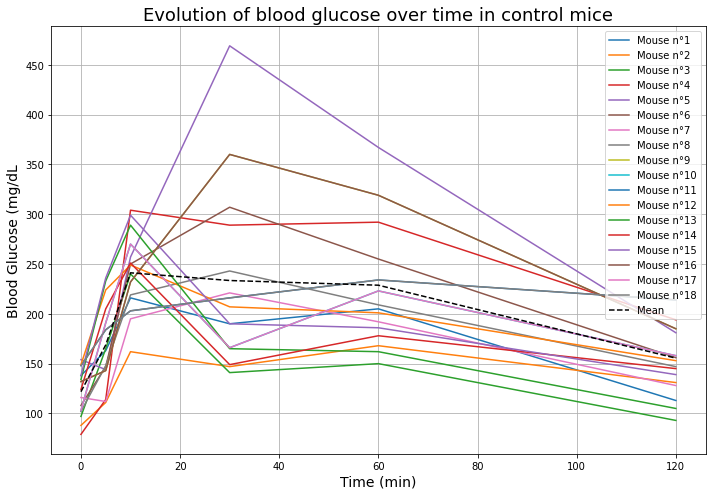

In [5]:
# Data transformation: adding an average
plt.rcParams["figure.figsize"] = [10, 7]

moy = np.ones((len(dctrl[:,1])-1,))
for k in range(len(moy)) :
    moy[k] = round(np.sum(dctrl[k+1,1:])/len(dctrl[k+1,1:]),2)

for k in range(1,len(dctrl[1,:])):
    plt.plot(dctrl[1:,0],dctrl[1:,k], label = f'Mouse n°{k}')
plt.plot(dctrl[1:,0],moy, linestyle='--', color = 'k', label = 'Mean')
plt.grid()
plt.legend()
plt.title('Evolution of blood glucose over time in control mice',fontsize = 18)

plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)

plt.tight_layout()

plt.show()

In [6]:
# Optimization
def sse(param) :

    k,b,s,r,m = param
    y0 = [G0,Gs_ini,I_ini,U0]    
    y = odeint(Za,y0,dctrl[1:,0], args = (k,b,s,r,m))

    return np.sum((y[:,1]-moy)**2) + (k<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8


G0, U0, Gs_ini, I_ini = 2500, 0.04, 100, 10

minimum = fmin(sse, [ 0.01, 0.001, 0.1, 0.001, 0.1])
print(minimum)

Optimization terminated successfully.
         Current function value: 2086.479719
         Iterations: 558
         Function evaluations: 899
[7.76910056e-10 3.73824342e-03 4.84877691e-02 6.72293076e-05
 4.85537426e-02]


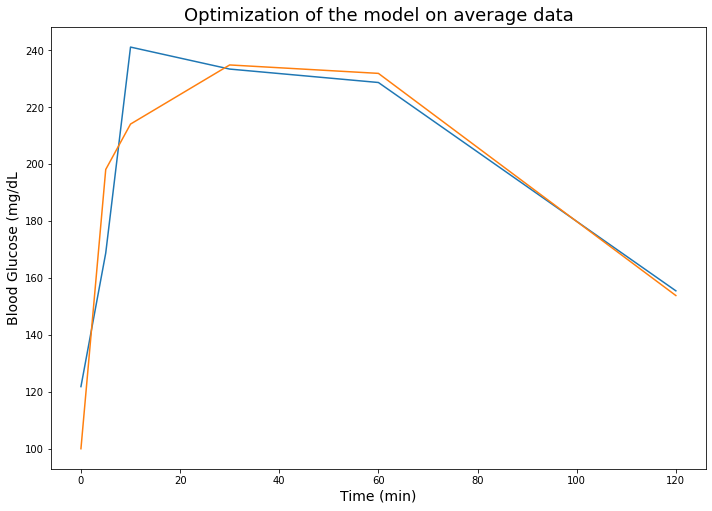

In [7]:
# Test
plt.rcParams["figure.figsize"] = [10, 7]

def Za1(Z,t):

    Gi, Gs, I, U = Z

    Gs_base = 150

    res = [
        -Gi*U ,        
        Gi*U - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I,
        -k*U
    ]

    return res

k,b,s,r,m = list(minimum)
y0 = [ G0, Gs_ini, I_ini, U0]
y = odeint(Za1,y0,dctrl[1:,0])

plt.rcParams["figure.figsize"] = [10, 7.2]

plt.plot(dctrl[1:,0],moy)
plt.plot(dctrl[1:,0],y[:,1])
plt.title('Optimization of the model on average data',fontsize = 18)

plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)

plt.tight_layout()
plt.show()

#### Apparently it seems to fit for the average
#### Obtaining the parameters of each mouse :

In [8]:
# Optimal settings for each mouse
Minimum = []
for i in range(1,len(dctrl[0])) :

    def sse(param) :

        k,b,s,r,m = param
        Gs_ini = dctrl[0,i]
        y0 = [G0,Gs_ini,I_ini,U0]    
        y = odeint(Za,y0,dctrl[1:,0], args = (k,b,s,r,m))

        return np.sum((y[:,1]-dctrl[1:,i])**2) + (k<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8

    Minimum.append(fmin(sse, minimum))

Optimization terminated successfully.
         Current function value: 2285.250493
         Iterations: 291
         Function evaluations: 475
Optimization terminated successfully.
         Current function value: 1469.203405
         Iterations: 117
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: 4417.207246
         Iterations: 194
         Function evaluations: 331
Optimization terminated successfully.
         Current function value: 17729.640229
         Iterations: 396
         Function evaluations: 653
Optimization terminated successfully.
         Current function value: 1517.987972
         Iterations: 355
         Function evaluations: 589
Optimization terminated successfully.
         Current function value: 2448.065139
         Iterations: 414
         Function evaluations: 692
Optimization terminated successfully.
         Current function value: 4037.909161
         Iterations: 235
         Function evaluations: 40

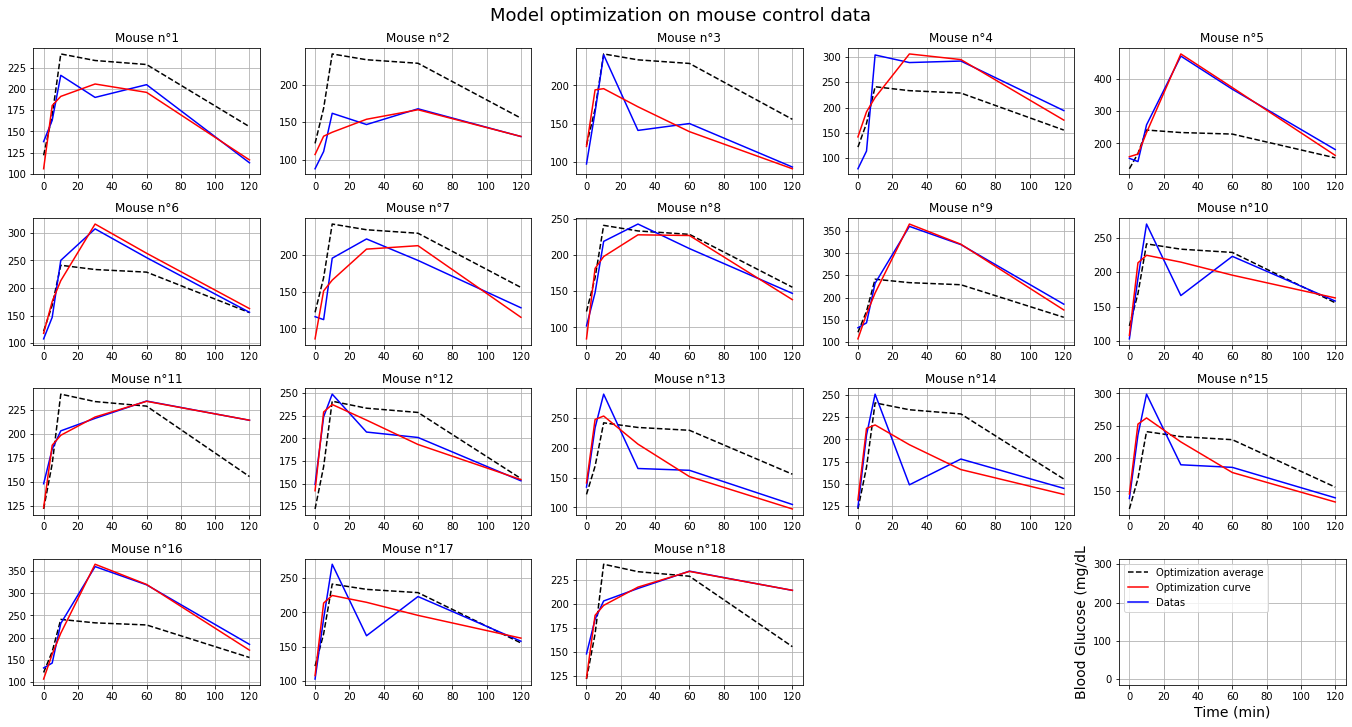

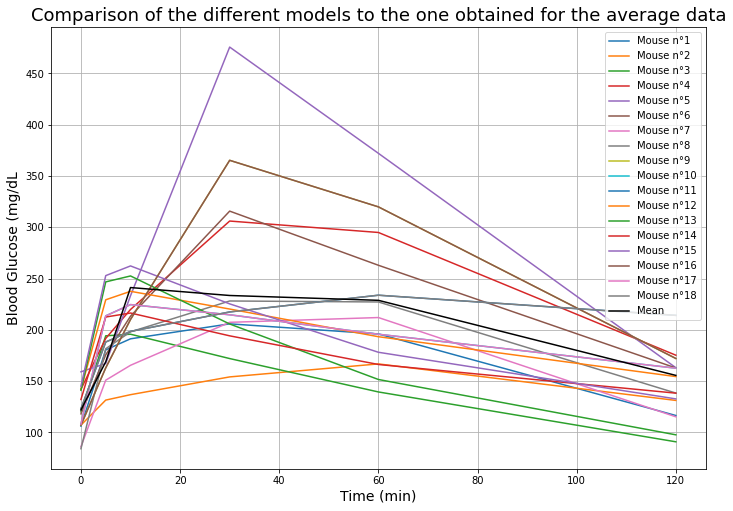

In [9]:
# Display of the curves of each mouse

def Za1(Z,t):

    Gi, Gs, I, U = Z

    Gs_base = 150

    res = [
        -Gi*U ,        
        Gi*U - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I,
        -k*U
    ]

    return res

plt.rcParams["figure.figsize"] = [19, 10]

plt.figure()
plt.suptitle('Model optimization on mouse control data',fontsize = 18)
for i in range(len(Minimum)) :

    plt.subplot(4,5,i+1)
    k,b,s,r,m = list(Minimum[-1])
    Gs_ini = dctrl[0,i+1]
    y0 = [G0,Gs_ini,I_ini,U0]  
    y = odeint(Za1,y0,dctrl[1:,0])    
    plt.plot(dctrl[1:,0],moy, color = 'k', linestyle='--')
    
    k,b,s,r,m = list(Minimum[i])
    Gs_ini = dctrl[0,i+1]
    y0 = [G0,Gs_ini,I_ini,U0]  
    y = odeint(Za1,y0,dctrl[1:,0])

    plt.plot(dctrl[1:,0],dctrl[1:,i+1], color = 'b')
    plt.plot(dctrl[1:,0],y[:,1], color = 'r')
    plt.grid()
    plt.title(f"Mouse n°{i+1}")

plt.subplot(4,5,20)

plt.plot(0,0,color='k',linestyle='--',label = "Optimization average")
plt.plot(0,0,color='r',label = "Optimization curve")
plt.plot(0,0,color='b',label = "Datas")
plt.plot(120,300)
plt.tight_layout()
plt.grid()
plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)
plt.legend()

plt.rcParams["figure.figsize"] = [10, 7.2]
plt.figure()
for i in range(len(Minimum)) :

    k,b,s,r,m = list(Minimum[i])
    Gs_ini = dctrl[0,i+1]
    y0 = [G0,Gs_ini,I_ini,U0]  
    y = odeint(Za1,y0,dctrl[1:,0])    
    plt.plot(dctrl[1:,0],y[:,1], label = f'Mouse n°{i+1}')
    
k,b,s,r,m = list(Minimum[-1])
y = odeint(Za1,y0,dctrl[1:,0])    
plt.plot(dctrl[1:,0],moy,'k', label = 'Mean')
plt.grid()
plt.legend()
plt.title('Comparison of the different models to the one obtained for the average data',fontsize = 18)
plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)

plt.tight_layout()
plt.show()

#### It seems that the average data 'fit' more than the individual optimal data
#### Applications on KO datas :

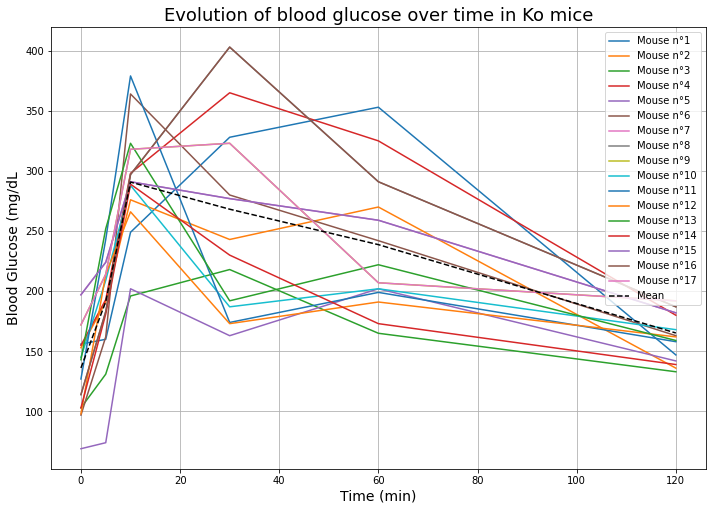

In [10]:
# Data transformation: adding an average
plt.rcParams["figure.figsize"] = [10, 7.2]
moy2 = np.ones((len(dko[:,1])-1,))
for k in range(len(moy2)) :
    moy2[k] = round(np.sum(dko[k+1,1:])/len(dko[k+1,1:]),2)

for k in range(1,len(dko[1,:])):
    plt.plot(dko[1:,0],dko[1:,k], label = f'Mouse n°{k}')
plt.plot(dko[1:,0],moy2, linestyle='--', color = 'k', label = 'Mean')
plt.grid()
plt.legend()
plt.title('Evolution of blood glucose over time in Ko mice',fontsize = 18)

plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)
plt.tight_layout()
plt.show()

In [11]:
# Optimization
def sse(param) :

    k,b,s,r,m = param
    y0 = [G0,Gs_ini,I_ini,U0]    
    y = odeint(Za,y0,dko[1:,0], args = (k,b,s,r,m))

    return np.sum((y[:,1]-moy2)**2) + (k<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8


G0, U0, Gs_ini, I_ini = 2500, 0.04, 100, 10

minimum = fmin(sse, [ 0.01, 0.001, 0.1, 0.001, 0.1])
print(minimum)

Optimization terminated successfully.
         Current function value: 4288.157243
         Iterations: 424
         Function evaluations: 698
[1.28228653e-09 3.57198425e-03 3.83872906e-02 6.47185515e-05
 4.43382653e-02]


In [12]:
# Optimal settings for each mouse
Minimum2 = []
for i in range(1,len(dko[0])) :

    def sse(param) :

        k,b,s,r,m = param
        Gs_ini = dko[0,i]
        y0 = [G0,Gs_ini,I_ini,U0]    
        y = odeint(Za,y0,dko[1:,0], args = (k,b,s,r,m))

        return np.sum((y[:,1]-dko[1:,i])**2) + (k<0)*1e8 + (b<0)*1e8 + (s<0)*1e8 +(r<0)*1e8 +(m<0)*1e8

    Minimum2.append(fmin(sse, minimum))

Optimization terminated successfully.
         Current function value: 2285.007448
         Iterations: 281
         Function evaluations: 454
Optimization terminated successfully.
         Current function value: 3363.936759
         Iterations: 304
         Function evaluations: 515
Optimization terminated successfully.
         Current function value: 584.008236
         Iterations: 359
         Function evaluations: 580
Optimization terminated successfully.
         Current function value: 4203.419778
         Iterations: 343
         Function evaluations: 567
Optimization terminated successfully.
         Current function value: 7262.210905
         Iterations: 126
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 15927.452463
         Iterations: 316
         Function evaluations: 514
Optimization terminated successfully.
         Current function value: 8437.634993
         Iterations: 235
         Function evaluations: 403

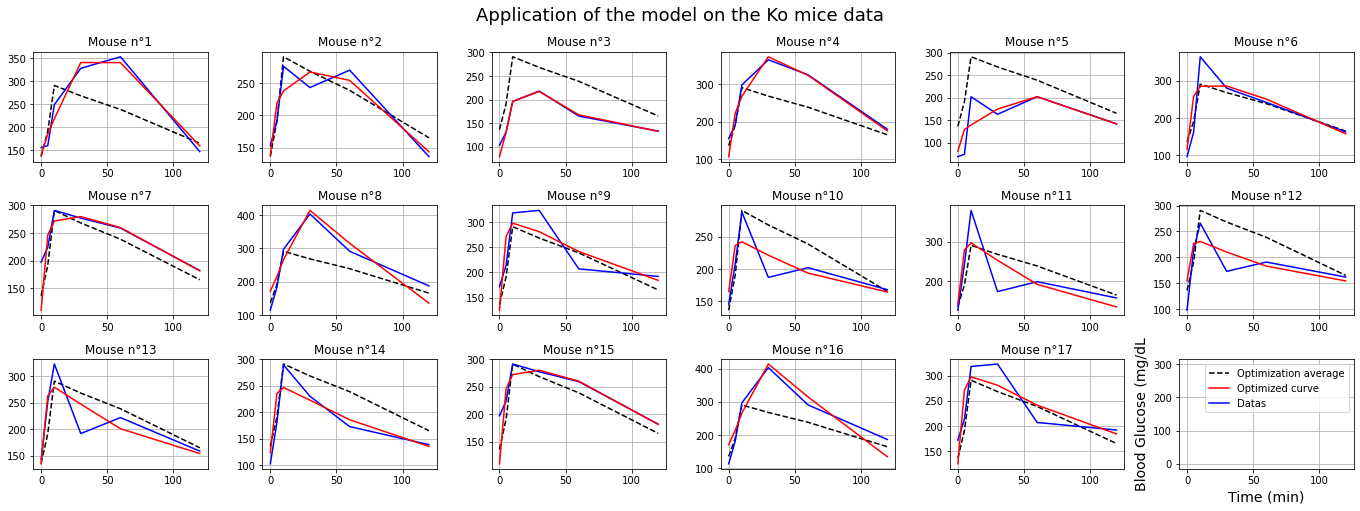

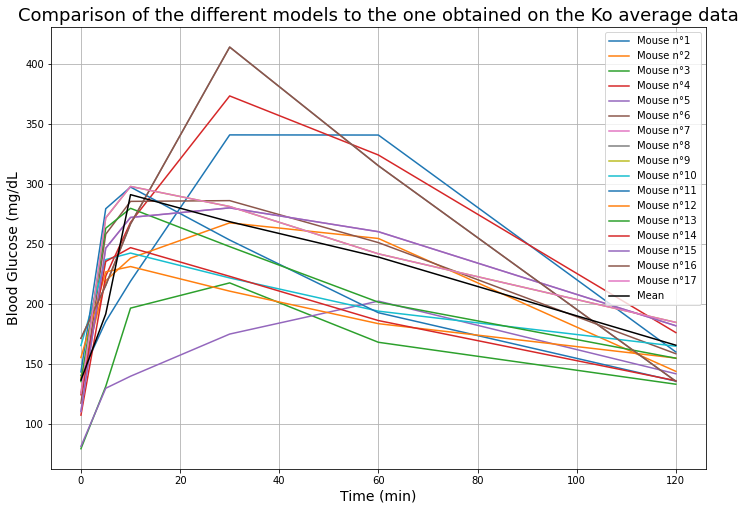

In [13]:
# Displaying the curves of each mouse
def Za1(Z,t):

    Gi, Gs, I, U = Z
    Gs_base = 150

    res = [
        -Gi*U ,        
        Gi*U - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I,
        -k*U
    ]

    return res


plt.rcParams["figure.figsize"] = [19, 7.2]
plt.figure()
plt.suptitle('Application of the model on the Ko mice data',fontsize = 18)
for i in range(len(Minimum2)) :

    plt.subplot(3,6,i+1)
    k,b,s,r,m = list(Minimum2[-1])
    Gs_ini = dko[0,i+1]
    y0 = [G0,Gs_ini,I_ini,U0]  
    y = odeint(Za1,y0,dko[1:,0])    
    plt.plot(dko[1:,0],moy2,color ='k', linestyle='--')
    
    k,b,s,r,m = list(Minimum2[i])
    Gs_ini = dko[0,i+1]
    y0 = [G0,Gs_ini,I_ini,U0]  
    y = odeint(Za1,y0,dko[1:,0])

    plt.plot(dko[1:,0],dko[1:,i+1], color = 'b')
    plt.plot(dko[1:,0],y[:,1], color = 'r')
    plt.grid()
    
    plt.title(f"Mouse n°{i+1}")

plt.subplot(3,6,18)

plt.plot(0,0,color='k',linestyle='--',label = "Optimization average")
plt.plot(0,0,color='r',label = "Optimized curve")
plt.plot(0,0,color='b',label = "Datas")
plt.plot(120,300)

plt.grid()
plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)
plt.tight_layout()
plt.legend()

plt.rcParams["figure.figsize"] = [10, 7.2]
plt.figure()
for i in range(0,len(Minimum2)) :

    k,b,s,r,m = list(Minimum2[i])
    Gs_ini = dko[0,i+1]
    y0 = [G0,Gs_ini,I_ini,U0]  
    y = odeint(Za1,y0,dko[1:,0])    
    plt.plot(dko[1:,0],y[:,1], label = f'Mouse n°{i+1}')
    
k,b,s,r,m = list(Minimum2[-1])
y = odeint(Za1,y0,dko[1:,0])    
plt.plot(dko[1:,0],moy2,'k', label = 'Mean')
plt.grid()
plt.title('Comparison of the different models to the one obtained on the Ko average data',fontsize = 18)
plt.legend()
plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)
plt.tight_layout()
plt.show()

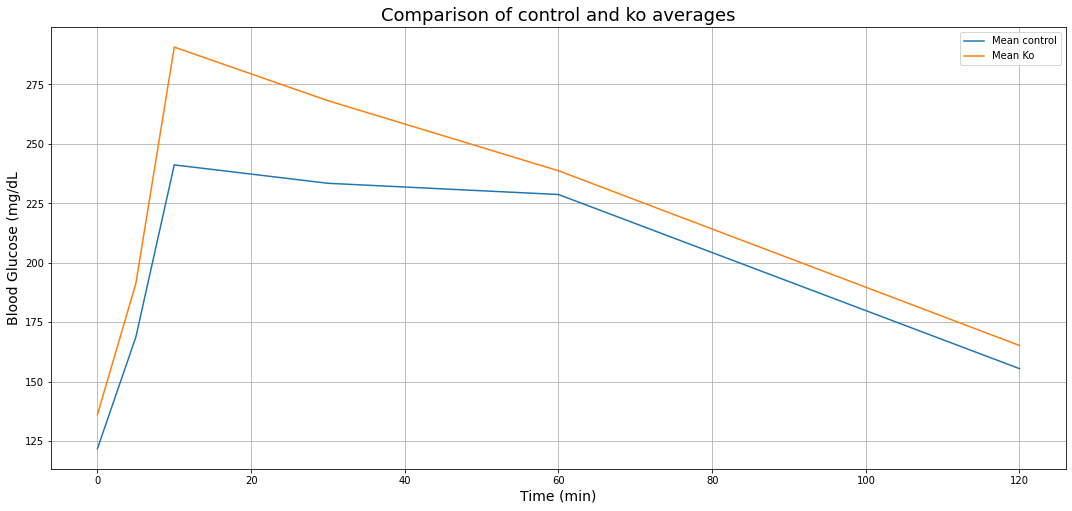

In [14]:
plt.rcParams["figure.figsize"] = [15, 7.2]

plt.title('Comparison of control and ko averages',fontsize = 18)
plt.plot(dctrl[1:,0],moy,label = 'Mean control')
plt.plot(dctrl[1:,0],moy2,label = 'Mean Ko')
plt.grid()
plt.legend()
plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)
plt.tight_layout()
plt.show()

In [15]:
A = np.asarray([7.76910056e-10, 3.73824342e-03, 4.84877691e-02, 6.72293076e-05, 4.85537426e-02]) # Average of the optimal parameters
B = np.asarray([1.28228653e-09, 3.57198425e-03, 3.83872906e-02, 6.47185515e-05, 4.43382653e-02]) # Optimal parameters for the first mouse
C = ((B/A)-1)*100 # Percentage of difference between the average and the first mouse
print(C)
print(B[0]/A[0])

[ 65.04954725  -4.44752124 -20.8309821   -3.73461544  -8.6820852 ]
1.6504954725415473


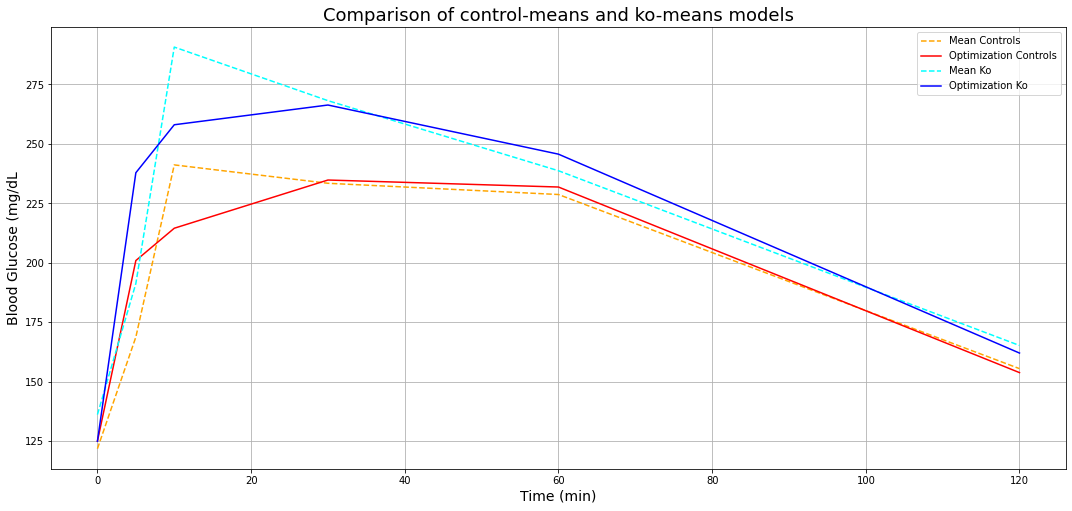

In [16]:
# Test
def Za1(Z,t):

    Gi, Gs, I, U = Z
    Gs_base = 150

    res = [
        -Gi*U ,        
        Gi*U - (s*I*Gs + b*max(0, Gs-Gs_base)),
        r*Gs - m*I,
        -k*U
    ]

    return res

plt.rcParams["figure.figsize"] = [15, 7.2]

k,b,s,r,m = [7.76910056e-10, 3.73824342e-03, 4.84877691e-02, 6.72293076e-05, 4.85537426e-02]
y0 = [ 2500, Gs_ini, I_ini, U0]
y1 = odeint(Za1,y0,dctrl[1:,0])

plt.plot(dctrl[1:,0],moy, color = 'orange',linestyle='--', label = 'Mean Controls')
plt.plot(dctrl[1:,0],y1[:,1], color = 'red',label = 'Optimization Controls')


k,b,s,r,m = [1.28228653e-09, 3.57198425e-03, 3.83872906e-02, 6.47185515e-05, 4.43382653e-02]
y0 = [ 2500, Gs_ini, I_ini, U0]
y2 = odeint(Za1,y0,dctrl[1:,0])

plt.plot(dctrl[1:,0],moy2, color = 'cyan',linestyle='--', label = 'Mean Ko')
plt.plot(dctrl[1:,0],y2[:,1],color = 'blue', label = 'Optimization Ko')




plt.title('Comparison of control-means and ko-means models',fontsize = 18)
plt.grid()
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Blood Glucose (mg/dL')
plt.xlabel('Time (min)',fontsize = 14)
plt.ylabel('Blood Glucose (mg/dL',fontsize = 14)
plt.tight_layout()
plt.show()